In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


root = Path.cwd().parents[0] if 'notebooks' in str(Path.cwd()) else Path.cwd()

train_path = root / "data" / "raw" / "train.csv"
test_path = root / "data" / "raw" / "test.csv"

train = pd.read_csv(train_path, parse_dates=['datetime'])
test = pd.read_csv(test_path, parse_dates=['datetime'])

print(f"Train verisi yüklendi: {train.shape}")
print(f"Test verisi yüklendi:  {test.shape}")


train['source'] = 'train'
test['source'] = 'test'
all_data = pd.concat([train, test], ignore_index=True, sort=False)

print(f"Birleştirilmiş veri boyutu: {all_data.shape}")

Train verisi yüklendi: (10886, 12)
Test verisi yüklendi:  (6493, 9)
Birleştirilmiş veri boyutu: (17379, 13)


In [2]:
all_data['date'] = all_data['datetime'].dt.date
all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['day'] = all_data['datetime'].dt.day
all_data['hour'] = all_data['datetime'].dt.hour
all_data['dayofweek'] = all_data['datetime'].dt.dayofweek  # 0: Pazartesi ... 6: Pazar

# Yeni Özellik: Hafta Sonu mu? (Cumartesi=5, Pazar=6)
# Eğer gün 5 veya 6 ise 1 (Evet), değilse 0 (Hayır) 
all_data['is_weekend'] = (all_data['dayofweek'] >= 5).astype(int)


print("Örnek Veri:")
print(all_data[['datetime', 'dayofweek', 'is_weekend']].head())

print("-" * 30)
print(f"Hafta sonu gün sayısı: {all_data['is_weekend'].sum()}")

Örnek Veri:
             datetime  dayofweek  is_weekend
0 2011-01-01 00:00:00          5           1
1 2011-01-01 01:00:00          5           1
2 2011-01-01 02:00:00          5           1
3 2011-01-01 03:00:00          5           1
4 2011-01-01 04:00:00          5           1
------------------------------
Hafta sonu gün sayısı: 5014


In [3]:
def get_time_of_day(hour):
    if 0 <= hour <= 6:
        return 0  # Gece (00:00 - 06:00)
    elif 7 <= hour <= 9:
        return 1  # Sabah Trafiği (07:00 - 09:00) -> Talep Patlar
    elif 10 <= hour <= 16:
        return 2  # Gündüz (10:00 - 16:00)
    elif 17 <= hour <= 19:
        return 3  # Akşam Trafiği (17:00 - 19:00) -> En Yüksek Talep
    else:
        return 4  # Gece Yarısı (20:00 - 23:00)


all_data['time_label'] = all_data['hour'].apply(get_time_of_day)


print("Zaman Dilimlerine Göre Veri Sayıları:")
print(all_data['time_label'].value_counts().sort_index())

Zaman Dilimlerine Göre Veri Sayıları:
time_label
0    5001
1    2181
2    5099
3    2186
4    2912
Name: count, dtype: int64


###  1. Aşama: Zaman Bazlı Özellikler (Temporal Features)

Ham `datetime` verisi model için anlamsızdır. Bu aşamada veriyi parçalayarak modelin anlayacağı ipuçları oluşturdu:

1.  **Temel Bileşenler:** Yıl, Ay, Gün ve Saat bilgilerini ayrı sütunlara çıkardık.
2.  **Hafta Sonu (`is_weekend`):** Cumartesi ve Pazar günlerini `1`, diğerlerini `0` olarak işaretledik. İnsanların hafta içi ve hafta sonu bisiklet kullanma amaçları farklıdır.
3.  **Zaman Dilimleri (`time_label`):** Saati sadece bir sayı olarak bırakmak yerine, günün evrelerine böldük:
    * `0`: Gece (Düşük Talep)
    * `1`: Sabah İşe Gidiş (Yüksek Talep)
    * `2`: Gündüz
    * `3`: Akşam İş Çıkışı (En Yüksek Talep)
    * `4`: Gece Yarısı

In [4]:
season_map = {
    1: "Spring",
    2: "Summer",
    3: "Fall",
    4: "Winter"
}

weather_map = {
    1: "Clear_FewClouds",
    2: "Mist_Cloudy",
    3: "Light_Rain_Snow",
    4: "Heavy_Rain_Ice"
}


all_data['season_label'] = all_data['season'].map(season_map)
all_data['weather_label'] = all_data['weather'].map(weather_map)

categorical_cols = ['season_label', 'weather_label']

print("Encoding öncesi sütun sayısı:", all_data.shape[1])

all_data = pd.get_dummies(all_data, columns=categorical_cols, prefix="", prefix_sep="")

all_data.drop(columns=['season', 'weather'], inplace=True)

print("Encoding sonrası sütun sayısı:", all_data.shape[1])

print("-" * 30)
print("Yeni oluşan 'Classy' sütunlardan örnekler:")
new_cols = list(season_map.values()) + list(weather_map.values())
existing_new_cols = [c for c in new_cols if c in all_data.columns]

print(all_data[existing_new_cols].head())

Encoding öncesi sütun sayısı: 23
Encoding sonrası sütun sayısı: 27
------------------------------
Yeni oluşan 'Classy' sütunlardan örnekler:
   Spring  Summer   Fall  Winter  Clear_FewClouds  Mist_Cloudy  Light_Rain_Snow  Heavy_Rain_Ice
0    True   False  False   False             True        False            False           False
1    True   False  False   False             True        False            False           False
2    True   False  False   False             True        False            False           False
3    True   False  False   False             True        False            False           False
4    True   False  False   False             True        False            False           False


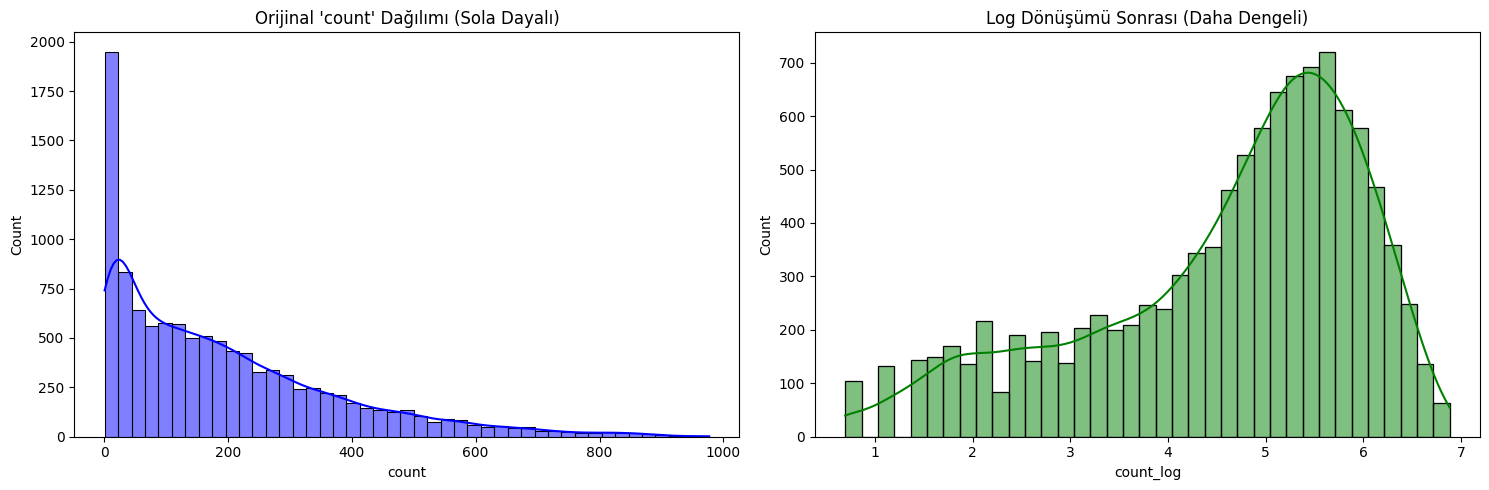

Dönüşüm tamamlandı. True/False'lar 1/0 oldu, count_log sütunu eklendi.


In [7]:
# True/False değerlerini 1/0'a çevirelim
# Sadece bool tipindeki sütunları seçip int yapıyoruz
bool_cols = all_data.select_dtypes(include=['bool']).columns
all_data[bool_cols] = all_data[bool_cols].astype(int)

all_data.loc[all_data['source'] == 'train', 'count_log'] = np.log1p(all_data.loc[all_data['source'] == 'train', 'count'])


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(all_data[all_data['source'] == 'train']['count'], ax=ax[0], kde=True, color='blue')
ax[0].set_title("Orijinal 'count' Dağılımı (Sola Dayalı)")

sns.histplot(all_data[all_data['source'] == 'train']['count_log'], ax=ax[1], kde=True, color='green')
ax[1].set_title("Log Dönüşümü Sonrası (Daha Dengeli)")


save_fig_path = root / "figures" / "feature_engineering_log_transform.png"
plt.savefig(save_fig_path)

plt.tight_layout()
plt.show()

print("Dönüşüm tamamlandı. True/False'lar 1/0 oldu, count_log sütunu eklendi.")

In [6]:
train_processed = all_data[all_data['source'] == 'train'].copy()
test_processed = all_data[all_data['source'] == 'test'].copy()


train_processed.drop(columns=['source'], inplace=True)
test_processed.drop(columns=['source', 'count', 'count_log'], inplace=True) 

save_train_path = root / "data" / "processed" / "train_processed.csv"
save_test_path = root / "data" / "processed" / "test_processed.csv"

train_processed.to_csv(save_train_path, index=False)
test_processed.to_csv(save_test_path, index=False)

print(f" İşlenmiş Train verisi kaydedildi: {train_processed.shape}")
print(f" İşlenmiş Test verisi kaydedildi:  {test_processed.shape}")
print(f"Dosya yolları:\n{save_train_path}\n{save_test_path}")


print("-" * 30)
print("Modelin kullanacağı özellikler (Sütunlar):")
print(train_processed.columns.tolist())

 İşlenmiş Train verisi kaydedildi: (10886, 27)
 İşlenmiş Test verisi kaydedildi:  (6493, 25)
Dosya yolları:
c:\Users\yedis\Desktop\yehu\Github Repo\BikeSharing-ML-Pipeline\data\processed\train_processed.csv
c:\Users\yedis\Desktop\yehu\Github Repo\BikeSharing-ML-Pipeline\data\processed\test_processed.csv
------------------------------
Modelin kullanacağı özellikler (Sütunlar):
['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'time_label', 'Fall', 'Spring', 'Summer', 'Winter', 'Clear_FewClouds', 'Heavy_Rain_Ice', 'Light_Rain_Snow', 'Mist_Cloudy', 'count_log']


In [8]:
print("Train Seti Sütunları:")
print(train_processed.columns.tolist())

Train Seti Sütunları:
['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend', 'time_label', 'Fall', 'Spring', 'Summer', 'Winter', 'Clear_FewClouds', 'Heavy_Rain_Ice', 'Light_Rain_Snow', 'Mist_Cloudy', 'count_log']


# Feature Engineering Özeti

Bu aşamada ham veriyi modelin anlayacağı "zeki" formatlara dönüştürdük ve sütun isimlerini insanlar tarafından okunabilir hale getirdik.

### Yapılan İşlemler ve Dönüşümler

| Özellik Grubu | Yapılan İşlem | Yeni Sütun Örnekleri | Neden? |
| :--- | :--- | :--- | :--- |
| **Zaman (Temporal)** | Saat, Gün, Ay ayrıştırıldı. Saatler "Sabah/Akşam" diye etiketlendi. | `hour`, `is_weekend`, `time_label` (0-4) | Modelin "İş Çıkış Saati" veya "Hafta Sonu" kavramlarını öğrenmesi için. |
| **Kategorik (Season)** | Sayısal (1,2,3,4) değerler isimlendirildi ve One-Hot yapıldı. | `season_Spring`, `season_Winter`... | Modelin "Kış > Yaz" gibi yanlış bir matematiksel büyüklük kurmasını engellemek için. |
| **Kategorik (Weather)** | Hava durumu kodları anlamlı kelimelere çevrilip One-Hot yapıldı. | `weather_Clear_FewClouds`, `weather_Mist_Cloudy`... | Analiz yaparken `weather_1` yerine ne olduğunu net görmek için. |
| **Hedef (Target)** | `count` değişkenine Logaritma uygulandı. | `count_log` | Sola dayalı (skewed) dağılımı düzelterek model hatasını azaltmak için. |

###  Çıktılar
* `data/processed/train_processed.csv`: Eğitime hazır veri.
* `data/processed/test_processed.csv`: Tahmin üretilecek sınav kağıdı.

**Sonraki Adım:** `04_model_training.ipynb` 